# **Predicciones en  Streaming con Spark**

En este notebook se carga un pipeline que tiene un conjunto de fases de pre-procesamiento y un modelo de clasificacion que pretende predecir la probabilidad de un paciente de sufrir un ataque al corazón. La predicción se realizará sobre datos en streaming optenidos a partir de la BD de heart en Kaggle

In [3]:
import findspark
findspark.init()

In [4]:
# trbajaremos con algunas herramietas disponibles en MLib
from pyspark.ml.feature import OneHotEncoder   #transformar a datos categóricos
from pyspark.ml.feature import MinMaxScaler    #Escala las características numéricas en un rango específico (por defecto entre 0 y 1)
from pyspark.ml.feature import StringIndexer   #Convierte columnas categóricas en índices numéricos (enteros)
from pyspark.ml.feature import VectorAssembler #Combinar múltiples columnas en un único vector
from pyspark.ml.feature import OneHotEncoder   #transforma una columna con categorías en múltiples columnas binarias (0 o 1), donde cada columna representa una categoría única(datos categóricos)
from pyspark.ml.classification import LogisticRegression  #Implementar el modelo de regresión logística para problemas de clasificación binaria o multiclase.
from pyspark.sql.types import *               #Proporciona tipos de datos explícitos para definir los esquemas de las columnas de un DataFrame en PySpark

In [5]:
## Iniciar una sesion de Spark

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('UCI Heart disease').getOrCreate()

In [6]:
## Cargar y visualizar el csv de Ejercicios\data\heart.csv con el nombre de heart
heart = spark.read.csv('C:/data/heart.csv', 
                       inferSchema = True, 
                       header = True)
heart.show(5)

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 63|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|
| 41|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|
| 56|  1|  1|     120| 236|  0|      1|    178|    0|    0.8|    2|  0|   2|     1|
| 57|  0|  0|     120| 354|  0|      1|    163|    1|    0.6|    2|  0|   2|     1|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
only showing top 5 rows



In [7]:
##Definamos el schema
schema = StructType( \
                     [StructField("age", LongType(),True), \
                      StructField("sex", LongType(), True), \
                      StructField("cp", LongType(), True), \
                      StructField('trestbps', LongType(), True), \
                      StructField("chol", LongType(), True), \
                      StructField("fbs", LongType(), True), \
                      StructField("restecg", LongType(), True), \
                      StructField("thalach", LongType(), True),\
                      StructField("exang", LongType(), True), \
                      StructField("oldpeak", DoubleType(), True), \
                      StructField("slope", LongType(),True), \
                      StructField("ca", LongType(), True), \
                      StructField("thal", LongType(), True), \
                      StructField("target", LongType(), True), \
                        ])

# **PipeLine**
En este caso el pipeline proporciona una forma de organizar y encadenar múltiples etapas del procesamiento y modelado de los datos en un flujo de trabajo secuencial.
Etapas de ejemplo: transformación de datos, entrenamiento de modelo, escalamiento.

In [8]:
from pyspark.ml import Pipeline
from pyspark.sql.types import (
    StructType,  # Para definir estructura de datos
    StructField,  # Para definir campos en la estructura
    LongType,     # Tipo de dato entero largo
    StringType,   # Tipo de dato cadena de texto
    DoubleType,   # Tipo de dato decimal de doble precisión
    TimestampType # Tipo de dato para marcas de tiempo
)

df = heart.withColumnRenamed("target","label")
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- label: integer (nullable = true)



In [9]:
##Dividir el dataframe en dos subconjuntos
testDF, trainDF = df.randomSplit([0.3, 0.7])

In [10]:
# Verificar que los DataFrames se hayan creado
print(f"Registros en conjunto de entrenamiento: {trainDF.count()}")
print(f"Registros en conjunto de prueba: {testDF.count()}")


Registros en conjunto de entrenamiento: 213
Registros en conjunto de prueba: 90


# **Cargar Pipeline**

In [11]:
import os
print(os.path.exists("C:/Ejercicios/pipelines"))


True


In [12]:
from pyspark.ml import Pipeline

# Configurar el pipeline (ejemplo)
vector_assembler = VectorAssembler(
    inputCols=['age', 'sex', 'cp', 'trestbps', 'chol', 'thalach', 'oldpeak'],
    outputCol="features"
)
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
logistic_regression = LogisticRegression(featuresCol="scaled_features", labelCol="label")

pipeline = Pipeline(stages=[vector_assembler, scaler, logistic_regression])
model = pipeline.fit(trainDF)  # Ajustar el modelo

# Guardar el modelo
model.write().overwrite().save("C:/Ejercicios/pipelines")


Tomaremos estas variables para predecir el riesgo de infarto. Las variables seleccionadas, se consideró están directamente relacionadas con factores de riesgo cardiovascular. Vamos a desglosar por qué son importantes:

* age: A mayor edad, mayor riesgo de infarto.
* sex: Hombres y mujeres tienen diferentes perfiles de riesgo cardíaco.
* cp(tipo de dolor en el pecho): El tipo de dolor torácico es un indicador clave.
* trestbps: La presión arterial alta es un factor de riesgo significativo.
* chol: Los niveles altos de colesterol aumentan el riesgo de obstrucción arterial.
* thalach: La frecuencia cardíaca máxima puede indicar problemas cardíacos.
* oldpeak: Depresión del segmento ST, un marcador de isquemia cardíaca.

In [13]:
from pyspark.ml import PipelineModel


pModel = PipelineModel.load("C:/Ejercicios/pipelines")

In [14]:
trainDF.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- label: integer (nullable = true)



In [15]:
# We transform the data.
trainingPred = pModel.transform(trainDF)

In [16]:
# # We select the actual label, probability and predictions
trainingPred.select('label', 'probability', 'prediction').show()

+-----+--------------------+----------+
|label|         probability|prediction|
+-----+--------------------+----------+
|    1|[0.01228453629417...|       1.0|
|    1|[0.13827458951468...|       1.0|
|    0|[0.87963049464408...|       0.0|
|    0|[0.61285359449726...|       0.0|
|    1|[0.12087201080686...|       1.0|
|    1|[0.32896328319477...|       1.0|
|    1|[0.06124965650513...|       1.0|
|    1|[0.00271167137436...|       1.0|
|    1|[0.02715076132558...|       1.0|
|    0|[0.45476169167131...|       1.0|
|    1|[0.05199769275755...|       1.0|
|    1|[0.06146500217487...|       1.0|
|    1|[0.06953707792234...|       1.0|
|    1|[0.00836988363552...|       1.0|
|    0|[0.35616968735951...|       1.0|
|    1|[0.03901256328229...|       1.0|
|    1|[0.40949511848392...|       1.0|
|    1|[0.00718835308692...|       1.0|
|    1|[0.28108397526770...|       1.0|
|    1|[0.04264204993525...|       1.0|
+-----+--------------------+----------+
only showing top 20 rows



In [20]:
testData = testDF.repartition(10)
testData

#Create a directory
testData.write.format("CSV").option("header",False).save("C:/Ejercicios/heart_streaming", mode="overwrite")

# **Predicciones en Streaming**

In [22]:
sourceStream = (
    spark.readStream.schema(schema)
    .option("maxFilesPerTrigger", 1)
    .csv("C:/Ejercicios/heart_streaming")
    .withColumnRenamed("output","label")
)

In [24]:
sourceStream.printSchema()

root
 |-- age: long (nullable = true)
 |-- sex: long (nullable = true)
 |-- cp: long (nullable = true)
 |-- trestbps: long (nullable = true)
 |-- chol: long (nullable = true)
 |-- fbs: long (nullable = true)
 |-- restecg: long (nullable = true)
 |-- thalach: long (nullable = true)
 |-- exang: long (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: long (nullable = true)
 |-- ca: long (nullable = true)
 |-- thal: long (nullable = true)
 |-- target: long (nullable = true)



In [26]:
sourceStream = sourceStream.withColumnRenamed("target", "label")
sourceStream.printSchema()

root
 |-- age: long (nullable = true)
 |-- sex: long (nullable = true)
 |-- cp: long (nullable = true)
 |-- trestbps: long (nullable = true)
 |-- chol: long (nullable = true)
 |-- fbs: long (nullable = true)
 |-- restecg: long (nullable = true)
 |-- thalach: long (nullable = true)
 |-- exang: long (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: long (nullable = true)
 |-- ca: long (nullable = true)
 |-- thal: long (nullable = true)
 |-- label: long (nullable = true)



In [27]:
sourceStream = sourceStream.select('age', 'sex', 'cp', 'trestbps', 'chol', 'thalach', 'oldpeak', 'label')

In [28]:
prediction1 = pModel.transform(sourceStream).select('label',
                                                   'probability',
                                                   'prediction')

In [29]:
display(prediction1)

DataFrame[label: bigint, probability: vector, prediction: double]

#### **Guardar una presentación en consola**

In [30]:
query1 = prediction1.writeStream.queryName("prediction1") \
            .format("console")\
            .trigger(once=True)\
            .start()\
            .awaitTermination()

#### **Guardar predicciones en memoria**

In [31]:
query2 = (
            prediction1.writeStream.queryName("prediction4") 
            .format("memory")
            .outputMode("append")
            .start())

In [32]:
for x in range(2):
    df = spark.sql(
        "SELECT * FROM prediction4")
    df.show(10)
df

+-----+--------------------+----------+
|label|         probability|prediction|
+-----+--------------------+----------+
|    0|[0.92537591395097...|       0.0|
|    0|[0.98779349779824...|       0.0|
|    1|[0.09647543479485...|       1.0|
|    1|[0.01478802363210...|       1.0|
|    1|[0.08133834893628...|       1.0|
|    1|[0.07263885386861...|       1.0|
|    0|[0.42416996683704...|       1.0|
|    0|[0.26581956847365...|       1.0|
|    1|[0.26147699042864...|       1.0|
|    0|[0.97262767497817...|       0.0|
+-----+--------------------+----------+
only showing top 10 rows

+-----+--------------------+----------+
|label|         probability|prediction|
+-----+--------------------+----------+
|    0|[0.92537591395097...|       0.0|
|    0|[0.98779349779824...|       0.0|
|    1|[0.09647543479485...|       1.0|
|    1|[0.01478802363210...|       1.0|
|    1|[0.08133834893628...|       1.0|
|    1|[0.07263885386861...|       1.0|
|    0|[0.42416996683704...|       1.0|
|    0|[0.2658

DataFrame[label: bigint, probability: vector, prediction: double]

In [ ]:
pip install scikit-learn

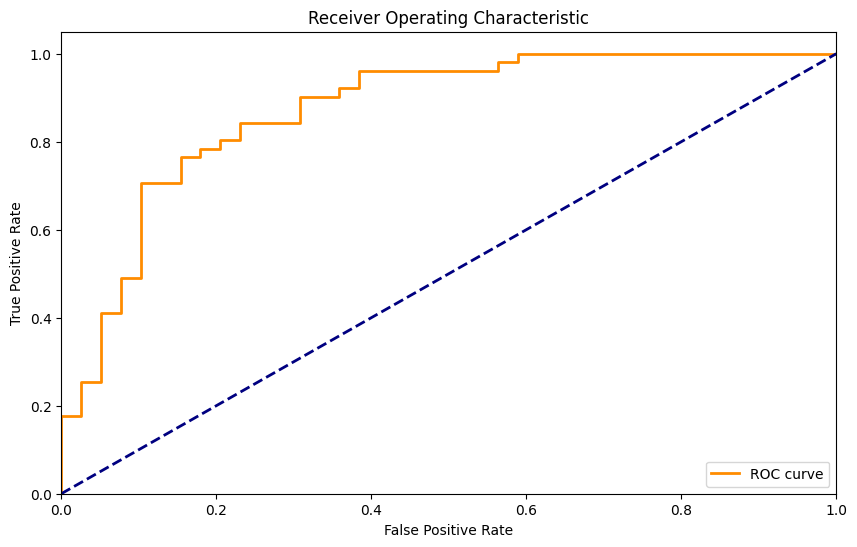

In [40]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve

# Seleccionamos las probabilidades y las etiquetas
labels_and_scores = predictions.select("label", "rawPrediction").rdd.map(lambda row: (row[0], row[1][1]))

# Convertimos a un DataFrame para usarlo con scikit-learn
labels_and_scores = labels_and_scores.collect()
labels = [x[0] for x in labels_and_scores]
scores = [x[1] for x in labels_and_scores]

# Calculamos la curva ROC con scikit-learn
fpr, tpr, thresholds = roc_curve(labels, scores)

# Graficamos la curva ROC
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()